# Trees

**Hinweis:** Da bei Tree-Modellen der Input in einen eindimensionalen Vektor vorliegt gehen Zusammenhangsstrukturen nebeneinanderliegender Pixel verloren. Aus diesem Grund stellt diese Art von Netzwerk eine falsche Modelklasse dar. Wir haben es zur Veranschaulichung und der Aufgabenstellung trotzdem kurz gezeigt.

#### Imports

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.auto import tqdm

#### Daten einlesen

**Hinweis:** Die Daten wurden in einer pkl-Datei gespeichert, um nicht jedes mal die Vorverarbeitung durchführen zu müssen und unkompliziert zwischen den Modelklassen hin- und her wechseln zu können

In [19]:
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size
X, y = data['data'], data['Species']
# Wir hatten massive Probleme mit der Begrenztheit unseres RAMs, weshalb wir versucht haben die Usage an mehreren Stellen zu reduzieren
X, y = np.stack(X).astype(np.float16), y.to_numpy().astype(np.uint8)

**Hinweis:** Im Folgenden wird ausschließlich der CART-Algorithmus verwendet, dieser erstellt ausschließlich Binärbäume.

## Funktion für einfachen Decision Tree
Mit den folgenden Funktionen können einfache Entscheidungsbäume erstellt und ausgewertet werden.

In [20]:
def fit_tree(X_train, y_train, max_depth=1, criterion="gini", min_samples_leaf=4):
    tree = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
    tree.fit(X_train,y_train)

    return tree

def evaluate_model(model, X_train, y_train, X_test, y_test,):
    # Predictions
    y_hat_tr = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    #Accuracy Score
    tr_score = model.score(X_train, y_train, sample_weight=None)
    test_score = model.score(X_test, y_test, sample_weight=None)
    
    # F1 Score
    f1_tr_score = f1_score(y_train, y_hat_tr, average='weighted')
    f1_test_score = f1_score(y_test, y_hat_test, average='weighted')


    return  tr_score, test_score,  f1_tr_score, f1_test_score

### Einfacher Decision Trees
Im Folgenden werden verschiedene Hyperparameter getestet.

In [21]:
# Hyperparameter
max_depth_values = range(1,20)
criterion_values = ["gini", "entropy"]

train_acc_dict = dict()
test_acc_dict = dict()
f1_train_dict = dict()
f1_test_dict = dict()

for depth in tqdm(max_depth_values):
    for criterion in tqdm(criterion_values):
        # Trainings- und Testdaten aufteilen
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        
        # Modell trainieren
        model = fit_tree(X_train, y_train, max_depth=depth, criterion=criterion)
        
        # Modell evaluieren
        train_acc, test_acc, f1_train, f1_test = evaluate_model(model, X_train, y_train, X_test, y_test)
        
        # Ergebnisse speichern
        train_acc_dict[(depth, criterion)] = train_acc
        test_acc_dict[(depth, criterion)] = test_acc
       
        f1_train_dict[(depth, criterion)] = f1_train
        f1_test_dict[(depth, criterion)] = f1_test

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Plotten der Scores
Im Folgenden werden die zuvor erstellten Bäume geplottet. Dadurch kann leicht erkannt werden, wie die Bäume auf die jeweiligen Daten performen (overfitting).

### Accuracy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

depths = range(1, 20)
criterion_values = ["gini", "entropy"]

# Extrahiere die Test- und Trainingsgenauigkeiten für die verschiedenen Kriterien
train_accs_gini = [train_acc_dict[(depth, 'gini')] for depth in depths]
test_accs_gini = [test_acc_dict[(depth, 'gini')] for depth in depths]

train_accs_entropy = [train_acc_dict[(depth, 'entropy')] for depth in depths]
test_accs_entropy = [test_acc_dict[(depth, 'entropy')] for depth in depths]


plt.figure(figsize=(10, 6))
plt.plot(depths, train_accs_gini, marker='o', label='Train accuracy (gini)')
plt.plot(depths, test_accs_gini, marker='o', label='Test accuracy (gini)')
plt.plot(depths, train_accs_entropy, marker='o', label='Train accuracy (entropy)')
plt.plot(depths, test_accs_entropy, marker='o', label='Test accuracy (entropy)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Max Depths and Criteria')
plt.xticks(np.arange(1, 20, step=1))
plt.legend()
plt.grid(True)
plt.show()

KeyError: (3, 'gini')

### F1-Score

**Hinweis:** Das Model ordnet einfach die meisten Punkte zu der größten Klasse zu, was beim F1-Score anders als bei der Accuracy bestraft wird.

In [ ]:
#F1 Score
train_f1_gini = [f1_train_dict[(depth, 'gini')] for depth in depths]
test_f1_gini = [f1_test_dict[(depth, 'gini')] for depth in depths]

train_f1_entropy = [train_acc_dict[(depth, 'entropy')] for depth in depths]
test_f1_entropy = [f1_test_dict[(depth, 'entropy')] for depth in depths]

plt.figure(figsize=(10, 6))
plt.plot(depths, train_f1_gini, marker='o', label='Train accuracy (gini)')
plt.plot(depths, test_f1_gini, marker='o', label='Test accuracy (gini)')
plt.plot(depths, train_f1_entropy, marker='o', label='Train accuracy (entropy)')
plt.plot(depths, test_f1_entropy, marker='o', label='Test accuracy (entropy)')
plt.xlabel('Max Depth')
plt.ylabel('F1')
plt.title('F1-Score for Different Max Depths and Criteria')
plt.xticks(np.arange(1, 20, step=1))
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'depths' is not defined

**Hinweis:** Mit zunehmender Tiefe ist ein zunehmendes overfitting zu erkennen. Um dies zu vermindern wäre die Wahl der richtigen Hyperparameter nötig.(max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes) Dies wurde auch vereinzelt getestet, aber da es sich um eine falsche Modellklasse handelt, haben wir uns eher auf das CNN und die Datenvorverarbeitung konzentriert.

#### k-Fold-Cross-Validation

Wir benutzen 10-Fold-Cross-Validation, um das Ergebnis weniger vom gewählten Split abhängig zu machen und somit das Ergebnis zu stabilisieren. Statified stellt sicher, dass die Klasseneinteilung beibehalten wird. Dies ist vor allem ohne Resampling interessant, da wir extrem ungleich verteilte Klassen haben.

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

### Random Forest
Wir versuchen mit einer ensemble-Methode das Ergebnis zu verbessern.

In [ ]:
# Hyperparameter
i_estimators = range(1, 250, 25)
leaf_nodes = range(2, 16, 2)

random_train_acc_dict = dict()
random_test_acc_dict = dict()
random_f1_train_dict = dict()
random_f1_test_dict = dict()

for estimators in tqdm(i_estimators):
    for nodes in tqdm(leaf_nodes):
        train_acc_list, test_acc_list, f1_train_list, f1_test_list = list(), list(), list(), list()

        for train_idx, test_idx in kfold.split(X_train, y_train):
            rnd_clf = RandomForestClassifier(n_estimators=estimators, max_leaf_nodes=nodes, n_jobs=-1)
            rnd_clf.fit(X_train[train_idx], y_train[train_idx])

            train_acc, test_acc, f1_train, f1_test = evaluate_model(rnd_clf, X_train[train_idx], y_train[train_idx],
                                                                   X_train[test_idx], y_train[test_idx])

            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            f1_train_list.append(f1_train)
            f1_test_list.append(f1_test)

        mean_train_acc = np.mean(train_acc_list)
        mean_test_acc = np.mean(test_acc_list)
        mean_f1_train = np.mean(f1_train_list)
        mean_f1_test = np.mean(f1_test_list)

        random_train_acc_dict[(estimators, nodes)] = mean_train_acc
        random_test_acc_dict[(estimators, nodes)] = mean_test_acc
        random_f1_train_dict[(estimators, nodes)] = mean_f1_train
        random_f1_test_dict[(estimators, nodes)] = mean_f1_test
        

100%|██████████| 10/10 [33:30<00:00, 201.05s/it]


#### Auswertung des Trainings- und Testprozesses

In [ ]:
# Um die Ergebnisse plotten zu können, werden sie in Listen umgewandelt
estimators_list = list(i_estimators)
leaf_nodes_list = list(leaf_nodes)

train_accuracy_array = np.array([[random_train_acc_dict[(est, node)] for node in leaf_nodes_list] for est in estimators_list])
test_accuracy_array = np.array([[random_test_acc_dict[(est, node)] for node in leaf_nodes_list] for est in estimators_list])

# Erstelle ein Konturlinien-Diagramm für Trainingsgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, train_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Trainingsgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Trainingsgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()

# Erstelle ein Konturlinien-Diagramm für Testgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, test_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Testgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Testgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()

NameError: name 'i_estimators' is not defined

**Hinweis:** Bei der verwendeten Gittersuche ist erkannbar, dass durch die Regulierung der maximalen Blätter und der steigenden Anzahl von verwendeten Bäumen, nur leichte Veränderung erkennbar sind. 
Nur an den unteren Rändern, der Grafiken, ist eine Veränderung der Test- und Trainingsgenauigkeit erkennbar. Das Modell zeigt:  Hier findet eine Überanpassung statt, dadruch steigt zwar die Trainingsgenauigkeit, einher stinkt jeoch die Testgenauigkeit.

**Auswertung:**
Trotz der Regeulierungen kann kein herausstechendes Modell mit passenden Paramtern gefunden werden.

### Extra Trees -  Extremly Randomized Trees

Eine Abwandlung des Random Forrest, welche aber die Feature-Seperation-Trashholds auch zufällig wählt => weniger overfitting durch diversere Bäume.

In [ ]:
# Hyperparameter
i_estimators = range(1, 250, 25)
leaf_nodes = range(2, 16, 2)

extra_train_acc_dict = dict()
extra_test_acc_dict = dict()
extra_f1_train_dict = dict()
extra_f1_test_dict = dict()

for estimators in tqdm(i_estimators):
    for nodes in tqdm(leaf_nodes):
        train_acc_list, test_acc_list, f1_train_list, f1_test_list = list(), list(), list(), list()

        for train_idx, test_idx in kfold.split(X_train, y_train):
            rnd_clf = ExtraTreesClassifier(n_estimators=estimators, max_leaf_nodes=nodes, n_jobs=-1)
            rnd_clf.fit(X_train[train_idx], y_train[train_idx])

            train_acc, test_acc, f1_train, f1_test = evaluate_model(rnd_clf, X_train[train_idx], y_train[train_idx],
                                                                   X_train[test_idx], y_train[test_idx])

            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            f1_train_list.append(f1_train)
            f1_test_list.append(f1_test)

        mean_train_acc = np.mean(train_acc_list)
        mean_test_acc = np.mean(test_acc_list)
        mean_f1_train = np.mean(f1_train_list)
        mean_f1_test = np.mean(f1_test_list)

        extra_train_acc_dict[(estimators, nodes)] = mean_train_acc
        extra_test_acc_dict[(estimators, nodes)] = mean_test_acc
        extra_f1_train_dict[(estimators, nodes)] = mean_f1_train
        extra_f1_test_dict[(estimators, nodes)] = mean_f1_test

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [59:29<55:44, 668.92s/it]  

#### Auswertung des Trainings- und Testprozesses

{(1, 2): 0.603390346115054, (1, 4): 0.6054506933744223, (1, 6): 0.6082165900242436, (1, 8): 0.6125731884135106, (1, 10): 0.613043332907542, (1, 12): 0.6168107260361585, (1, 14): 0.6171047326696313, (26, 2): 0.6028018338739995, (26, 4): 0.6028018338739995, (26, 6): 0.6028018338739995, (26, 8): 0.6029784152670997, (26, 10): 0.6031549689394161, (26, 12): 0.6042144850188014, (26, 14): 0.6071575729189675, (51, 2): 0.6028018338739995, (51, 4): 0.6028018338739995, (51, 6): 0.6028018338739995, (51, 8): 0.6028018338739995, (51, 10): 0.6029195640429943, (51, 12): 0.6035081871671844, (51, 14): 0.6050384575978456, (76, 2): 0.6028018338739995, (76, 4): 0.6028018338739995, (76, 6): 0.6028018338739995, (76, 8): 0.6028018338739995, (76, 10): 0.6030372664912051, (76, 12): 0.6030961454360945, (76, 14): 0.6043911218534692, (101, 2): 0.6028018338739995, (101, 4): 0.6028018338739995, (101, 6): 0.6028018338739995, (101, 8): 0.6028018338739995, (101, 10): 0.6028606850981049, (101, 12): 0.6030961454360945, (1

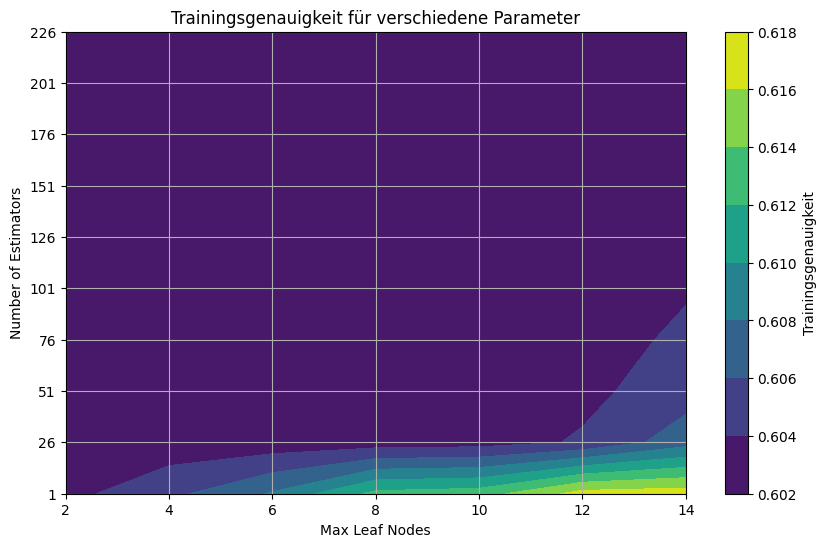

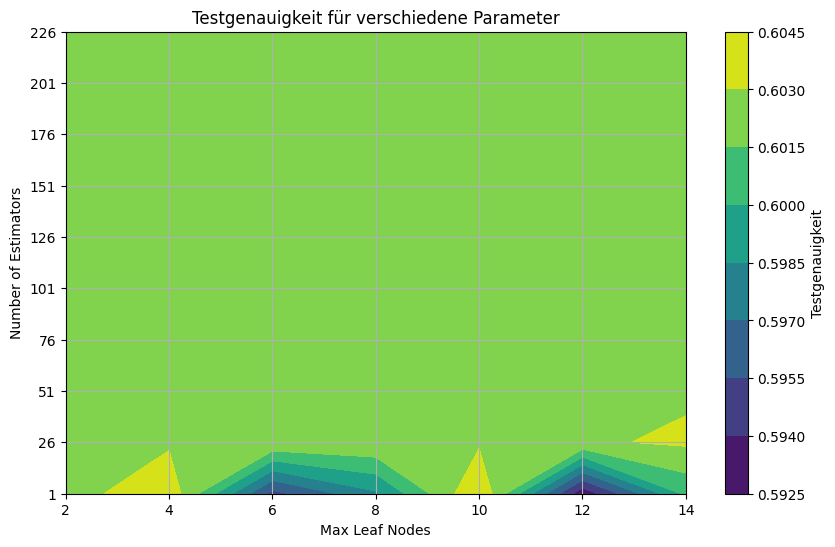

In [ ]:
# Um die Ergebnisse plotten zu können, müssen wir die Daten in Listen umwandeln
estimators_list = list(i_estimators)
leaf_nodes_list = list(leaf_nodes)

train_accuracy_array = np.array([[extra_train_acc_dict[(est, node)] for node in leaf_nodes_list] for est in estimators_list])
test_accuracy_array = np.array([[extra_test_acc_dict[(est, node)] for node in leaf_nodes_list] for est in estimators_list])

# Erstelle ein Konturlinien-Diagramm für Trainingsgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, train_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Trainingsgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Trainingsgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()

# Erstelle ein Konturlinien-Diagramm für Testgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, test_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Testgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Testgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()

**Auswertung:** Die Grafiken unterschieden sich kaum im Vergleich zu Random Forest. 

**Hinweis:** Der Eintausch von Bias gegen Varianz zeigt keine erwähnbaren Unterschiede => Klassenverteilung.

### Boosting

**Hinweis:** Vorab ist zu erwähnen, dass die Modelle schlechte Ergebnisse erzielen, da sie sich "das Leben zu einfach machen". Durch die Ungleichgewichtung der Klassen in den Daten und den Verlust der Struktur durch das Flatten ordnen die Boosting-Modelle alle Feldermausbilder der größten Klasse zu. Dies führt zu vermeintlich guten Ergebnissen, die jedoch trügerisch sind (was sich auch in den Konfusionsmatrizen widerspiegelt.




Nachfolgend sind  AdaBoost und Gradient Boosting zu finden.

#### AdaBoost

In [ ]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.7)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.7, n_estimators=200)

In [ ]:
ada_clf_train = ada_clf.predict(X_train)
ada_clf_test = ada_clf.predict(X_test)

train_accuracy = accuracy_score(y_train, ada_clf_train)
test_accuracy = accuracy_score(y_test, ada_clf_test)

train_f1 = f1_score(y_train, ada_clf_train, average='weighted')
test_f1 = f1_score(y_test, ada_clf_test, average='weighted')

labels = ['Train', 'Test']

print("Train F1 Score:", train_f1)
print("Test F1 Score:", test_f1)
print("train_accuracy", train_accuracy )
print("test_accuracy", test_accuracy)

Train F1 Score: 0.5033388892208134
Test F1 Score: 0.4704178727397549
train_accuracy 0.595797280593325
test_accuracy 0.5691358024691358


**Auswertung** AdaBoostClassifier liefert keine erheblich besseren Werte als die Verfahren zuvor. Der Test und Training F1-Score weicht von den anderen Baum-Modellen kaum ab.


**Hinweis:** Bei großer Learning-Rate ist die Rechenzeit des AdaBoostClassifier relativ kurz, da einfach nur immer die erste Klasse vorhergesagt wird. Dies war auch bei kleinerer Learning-Rate der Fall.

#### Gardient Boosting

In [ ]:
gbrt = GradientBoostingClassifier(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=118)

In [ ]:
errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors) + 1
gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

y_pred = gbrt_best.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(errors) + 1), errors, label='MSE auf Testdaten')
plt.axvline(bst_n_estimators, linestyle='--', color='red', label='Beste Anzahl von Schätzungen')
plt.xlabel('Anzahl der Schätzungen')
plt.ylabel('Mittlere quadratische Abweichung (MSE)')
plt.legend()
plt.title('Entwicklung des MSE mit der Anzahl der Schätzungen')
plt.show()

print("Beste Anzahl von Schätzungen:", bst_n_estimators)
print("Gewichteter F1-Score:", f1)

NameError: name 'gbrt' is not defined

##### Confusion Matrix

Man kann sehen, dass das Modell nichts gelernt hat, sondern einfach nur immer die erste Klasse vorhersagt.

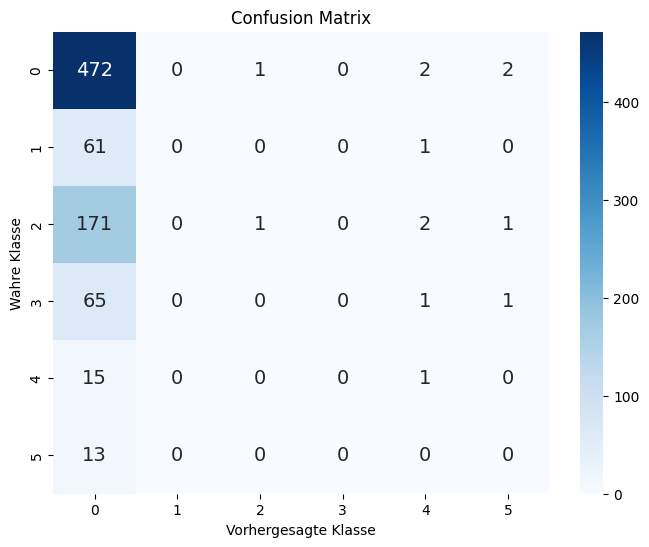

In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix, display_labels=classes)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()